In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.chdir('../../')

In [3]:
from musicautobot.numpy_encode import *
from musicautobot.config import *
from musicautobot.music_transformer import *
from musicautobot.multitask_transformer import *
from musicautobot.utils import midifile

# MusicItem Basics

MusicItem is simpe interface to load music files and manipulate tensors. It supports music playback and simple transformations

The [Midi2Tensor](Midi2Tensor.ipynb) notebook provides a more in depth guide to how the encoding works.

## Loading MusicItem

In [4]:
# Example File
midi_file = Path('data/midi/notebook_examples/single_bar_example.mid')

# Vocab defines how the item is represented as a tensor
vocab = MusicVocab.create()

In [5]:
# Load MusicItem
item = MusicItem.from_file(midi_file, vocab);

Functions:

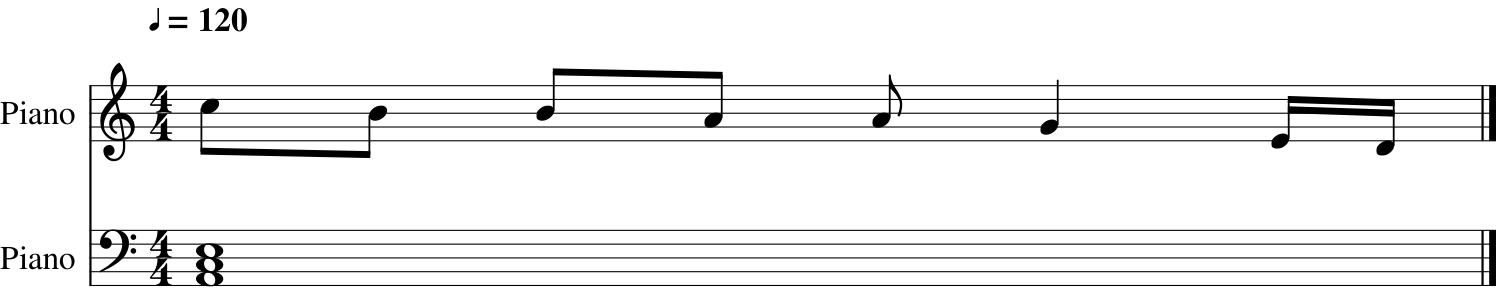

In [6]:
# Show score:
item.show()

In [7]:
# Play file:
item.play()

In [8]:
# Tensor representation:
item.to_tensor()

tensor([  0,   1,  81, 139,  61, 153,  57, 153,  54, 153,   8, 139,  80, 139,
          8, 139,  80, 139,   8, 139,  78, 139,   8, 139,  78, 139,   8, 139,
         76, 141,   8, 141,  73, 138,   8, 138,  71, 138], device='cuda:0')

In [9]:
# Text format:
item.to_text()

'xxbos xxpad n72 d2 n52 d16 n48 d16 n45 d16 xxsep d2 n71 d2 xxsep d2 n71 d2 xxsep d2 n69 d2 xxsep d2 n69 d2 xxsep d2 n67 d4 xxsep d4 n64 d1 xxsep d1 n62 d1'

In [10]:
# Music21 Stream
item.to_stream().show('text')

{0.0} <music21.stream.Part 0x7fdd4fd924a8>
    {0.0} <music21.instrument.Piano Piano>
    {0.0} <music21.note.Note C>
    {0.0} <music21.chord.Chord A2 C3 E3>
    {0.5} <music21.note.Note B>
    {1.0} <music21.note.Note B>
    {1.5} <music21.note.Note A>
    {2.0} <music21.note.Note A>
    {2.5} <music21.note.Note G>
    {3.5} <music21.note.Note E>
    {3.75} <music21.note.Note D>
{0.0} <music21.tempo.MetronomeMark animato Quarter=120>
{0.0} <music21.key.KeySignature of no sharps or flats>
{0.0} <music21.meter.TimeSignature 4/4>


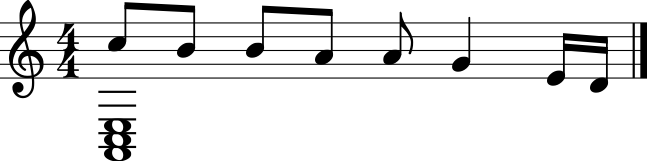

In [11]:
# Create Item from numpy array
new_item = item.new(item.data)
new_item.show()

### Transforms

Some basic transformations

#### Transpose

Useful for data augmentation

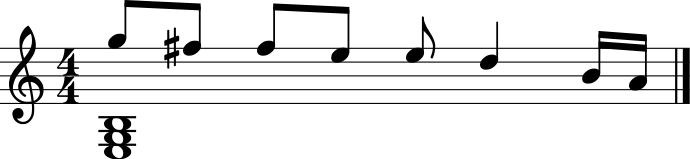

In [12]:
# Transpose from key of C to key of G
item_transpose = item.transpose(7)
item_transpose.show()

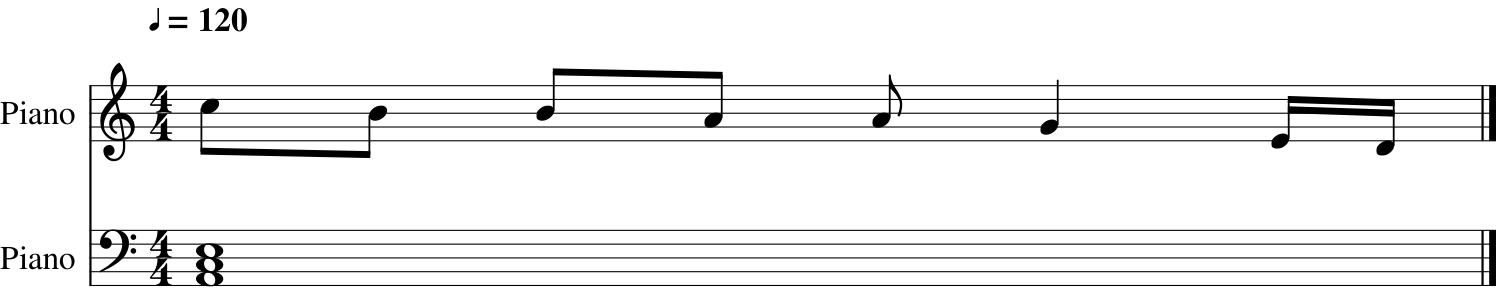

In [13]:
item.show()

#### Trim

Create a short clip for predictions

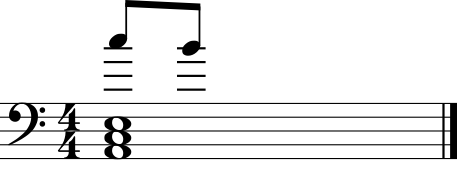

In [14]:
# Trim to first quarter note
item.trim_to_beat(1).show()

#### Positioning

Position = the timestep of each note.  
Multitask training uses this positional information to help it predict the next note

In [15]:
item.position

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  2,  2,  2,  4,  4,  4,  4,  6,  6,  6,  6,  8,  8,  8,  8,
       10, 10, 10, 10, 14, 14, 14, 14, 15, 15])

In [16]:
idx_str = item.to_text(sep=None)
list(zip(idx_str, item.position))

[('xxbos', 0),
 ('xxpad', 0),
 ('n72', 0),
 ('d2', 0),
 ('n52', 0),
 ('d16', 0),
 ('n48', 0),
 ('d16', 0),
 ('n45', 0),
 ('d16', 0),
 ('xxsep', 0),
 ('d2', 0),
 ('n71', 2),
 ('d2', 2),
 ('xxsep', 2),
 ('d2', 2),
 ('n71', 4),
 ('d2', 4),
 ('xxsep', 4),
 ('d2', 4),
 ('n69', 6),
 ('d2', 6),
 ('xxsep', 6),
 ('d2', 6),
 ('n69', 8),
 ('d2', 8),
 ('xxsep', 8),
 ('d2', 8),
 ('n67', 10),
 ('d4', 10),
 ('xxsep', 10),
 ('d4', 10),
 ('n64', 14),
 ('d1', 14),
 ('xxsep', 14),
 ('d1', 14),
 ('n62', 15),
 ('d1', 15)]

## MultitrackItem

When converting from MIDI file MusicItem, we lose track (melody vs chords) information.
We need this information for sequence to sequence training (MultitaskTransformer) - as we use the melody to predict chords and vice versa.

MultitrackItem retains the track information. Which notes belong to chords/melody.

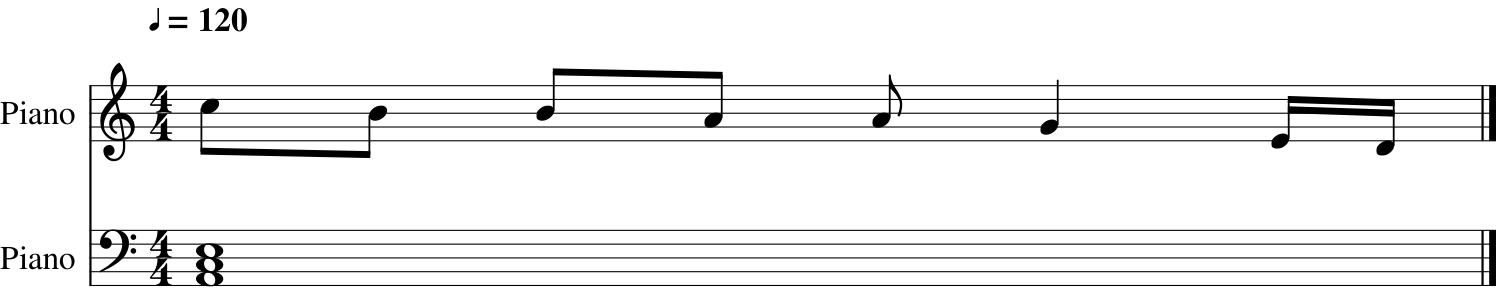

In [17]:
# Original File
file2stream(midi_file).show()

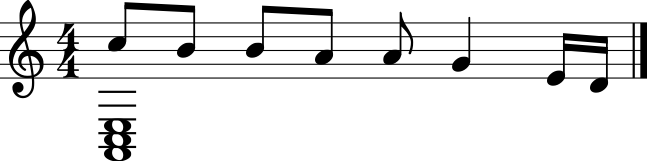

In [18]:
# MusicItem does NOT separate chords with melody
item.to_stream().show()

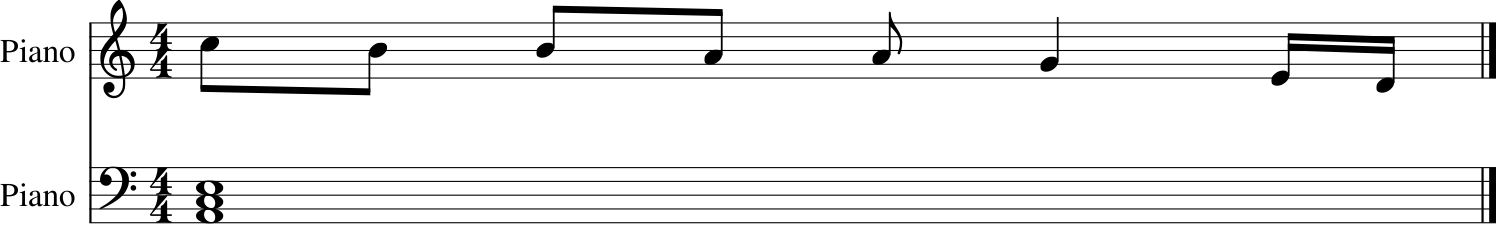

In [19]:
# Multitrack Item
mt_item = MultitrackItem.from_file(midi_file, vocab)
mt_item.to_stream().show()

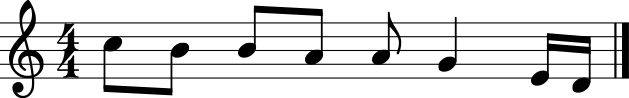

In [20]:
mt_item.melody.show()

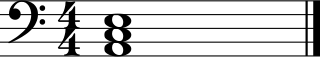

In [21]:
mt_item.chords.show()

In [22]:
# MultitrackItem is basically a composition of 2 MusicItems
type(mt_item.melody), type(mt_item.chords)

(musicautobot.music_transformer.transform.MusicItem,
 musicautobot.music_transformer.transform.MusicItem)

In [23]:
# Same transforms work
mt_item.transpose(4), mt_item.trim_to_beat(2)

(<musicautobot.multitask_transformer.transform.MultitrackItem at 0x7fdd4f4a49e8>,
 <musicautobot.multitask_transformer.transform.MultitrackItem at 0x7fdd4f485a58>)